# Package Installation and File read

In [1]:
from google.colab import drive
drive.mount('/content/drive/')

KeyboardInterrupt: ignored

In [ ]:
pip install geopandas

In [ ]:
!pip install plotly==4.6

In [ ]:
pip install plotly-express

In [ ]:
import pandas as pd
import geopandas as gpd
import plotly_express as px
import matplotlib.pyplot as plt

In [ ]:
path = '/content/drive/Shareddrives/ISE 534/Project Solution/Data Manipulation/tps2_staff_pass.csv'
#path = '/content/drive/Shareddrives/ISE 534/Project Solution/Data Manipulation/tps2_10files.csv'
#path = '/content/drive/Shareddrives/ISE 534/Raw Data/data/tps2_0-10/tps2000000000001'

In [ ]:
df0 = pd.read_csv(path)

In [ ]:
df0.head()

In [ ]:
df0.shape

# Data Cleaning - clean, remove duplicates, eliminate single Mac IDs

In [ ]:
df0 = df0.drop_duplicates()

In [ ]:
df0.shape

(12969501, 7)

In [ ]:
mac_count=pd.DataFrame(df0.ClientMacAddr.value_counts())
mac_count.reset_index(level=0, inplace=True)
mac_count.columns = ['ClientMacAddr', 'count'] 
mac_count[:5]

,ClientMacAddr,count
0,84:16:f9:ab:42:a8,120797
1,84:16:f9:ab:47:f8,115265
2,84:16:f9:ab:53:34,115218
3,18:d6:c7:e5:28:14,112208
4,84:16:f9:ab:47:ac,111969


In [ ]:
single_mac=mac_count[mac_count['count']==1]
single_mac=list(single_mac['ClientMacAddr'])
single_mac[:5]

[]

In [ ]:
#Eliminate the Mac IDs that only appear once
df = df0[~df0.ClientMacAddr.isin(single_mac)]
df.head()

,Building,Level,ClientMacAddr,lat,lng,localtime,category
0,TPS2,Level 1,00:87:01:05:7a:bc,-22.815060,-43.245462,2019-08-21 09:53:23.601 UTC,passenger
1,TPS2,Level 1,28:39:5e:15:23:74,-22.814001,-43.247166,2019-08-21 09:53:23.932 UTC,staff
2,TPS2,Level 1,38:01:95:9a:0f:a4,-22.815099,-43.244897,2019-08-21 09:53:24.043 UTC,staff
3,TPS2,Level 1,d8:0d:17:1d:da:22,-22.815048,-43.246064,2019-08-21 09:53:24.047 UTC,staff
4,TPS2,Level 1,38:80:df:30:eb:08,-22.815112,-43.246586,2019-08-21 09:53:24.157 UTC,staff


In [ ]:
df.shape

(12969501, 7)

In [ ]:
# remove the UTC
df['timestamp'] = df['localtime'].str[:23]

In [ ]:
df.drop(labels = "localtime", axis = 1,inplace = True)
df.head()

,Building,Level,ClientMacAddr,lat,lng,category,timestamp
0,TPS2,Level 1,00:87:01:05:7a:bc,-22.815060,-43.245462,passenger,2019-08-21 09:53:23.601
1,TPS2,Level 1,28:39:5e:15:23:74,-22.814001,-43.247166,staff,2019-08-21 09:53:23.932
2,TPS2,Level 1,38:01:95:9a:0f:a4,-22.815099,-43.244897,staff,2019-08-21 09:53:24.043
3,TPS2,Level 1,d8:0d:17:1d:da:22,-22.815048,-43.246064,staff,2019-08-21 09:53:24.047
4,TPS2,Level 1,38:80:df:30:eb:08,-22.815112,-43.246586,staff,2019-08-21 09:53:24.157


In [ ]:
# split into date and time
df['date'] = df['timestamp'].str[:10]
df['time'] = df['timestamp'].str[-12:]

In [ ]:
df.head()

,Building,Level,ClientMacAddr,lat,lng,category,timestamp,date,time
0,TPS2,Level 1,00:87:01:05:7a:bc,-22.815060,-43.245462,passenger,2019-08-21 09:53:23.601,2019-08-21,09:53:23.601
1,TPS2,Level 1,28:39:5e:15:23:74,-22.814001,-43.247166,staff,2019-08-21 09:53:23.932,2019-08-21,09:53:23.932
2,TPS2,Level 1,38:01:95:9a:0f:a4,-22.815099,-43.244897,staff,2019-08-21 09:53:24.043,2019-08-21,09:53:24.043
3,TPS2,Level 1,d8:0d:17:1d:da:22,-22.815048,-43.246064,staff,2019-08-21 09:53:24.047,2019-08-21,09:53:24.047
4,TPS2,Level 1,38:80:df:30:eb:08,-22.815112,-43.246586,staff,2019-08-21 09:53:24.157,2019-08-21,09:53:24.157


In [ ]:
df.dtypes

Building          object
Level             object
ClientMacAddr     object
lat              float64
lng              float64
category          object
timestamp         object
date              object
time              object
dtype: object

# Geofencing on Zone 1

In [ ]:
#Subselect the day that we want to look at
day = df[df['date'] == "2019-08-21"]

In [ ]:
#Subselect the specific time interval we want to look at
df_day_time = day[day["time"].between('09:00:00','10:00:00')]

In [ ]:
df_day_time.head()

,Building,Level,ClientMacAddr,lat,lng,category,timestamp,date,time
0,TPS2,Level 1,00:87:01:05:7a:bc,-22.815060,-43.245462,passenger,2019-08-21 09:53:23.601,2019-08-21,09:53:23.601
1,TPS2,Level 1,28:39:5e:15:23:74,-22.814001,-43.247166,staff,2019-08-21 09:53:23.932,2019-08-21,09:53:23.932
2,TPS2,Level 1,38:01:95:9a:0f:a4,-22.815099,-43.244897,staff,2019-08-21 09:53:24.043,2019-08-21,09:53:24.043
3,TPS2,Level 1,d8:0d:17:1d:da:22,-22.815048,-43.246064,staff,2019-08-21 09:53:24.047,2019-08-21,09:53:24.047
4,TPS2,Level 1,38:80:df:30:eb:08,-22.815112,-43.246586,staff,2019-08-21 09:53:24.157,2019-08-21,09:53:24.157


In [ ]:
# Convert Pandas Dataframe to GeoPandas Dataframe
gdf = gpd.GeoDataFrame(df_day_time, geometry=gpd.points_from_xy(df_day_time.lng, df_day_time.lat))

In [ ]:
#Api Key
# https://account.mapbox.com/access-tokens is where you create the API Key
px.set_mapbox_access_token("pk.eyJ1Ijoic2FiYmF0ZSIsImEiOiJja21xYjFsYjUwNXVmMndsa2JkbGdyM3p0In0.38ZFdcLm_3MceXSTQH7Fvg")

In [ ]:
#Plot the points
fig = px.scatter_mapbox(gdf,
                        lat=gdf.geometry.y,
                        lon=gdf.geometry.x,
                        zoom=8, width=1200, height=800)
fig.show()

In [ ]:
from shapely.geometry import Point, Polygon
import folium

In [ ]:
# Zone 1 Extreme Points - Specified in this array of (long,lat),(long,lat)...
coordinates = [(-43.24471246167892,-22.814458938651967),(-43.24527556323677,-22.81482206116928),(-43.2448346208758,-22.815398982183833),
               (-43.24418730395855,-22.814928090082798)]

In [ ]:
#Function to create Polygon (in this case Zone 1 - square)
def create_polygon(coords, polygon_name):
 polygon = Polygon(coords)
 gdf = gpd.GeoDataFrame(crs = {"init" :"epsg:4326"})
 gdf.loc[0,"name"] = polygon_name
 gdf.loc[0, "geometry"] = polygon
 return gdf

In [ ]:
zone1 = create_polygon(coordinates,"zone1")

/usr/local/lib/python3.7/dist-packages/pyproj/crs/crs.py:53: FutureWarning:

'+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: FutureWarning:

Assigning CRS to a GeoDataFrame without a geometry column is now deprecated and will not be supported in the future.



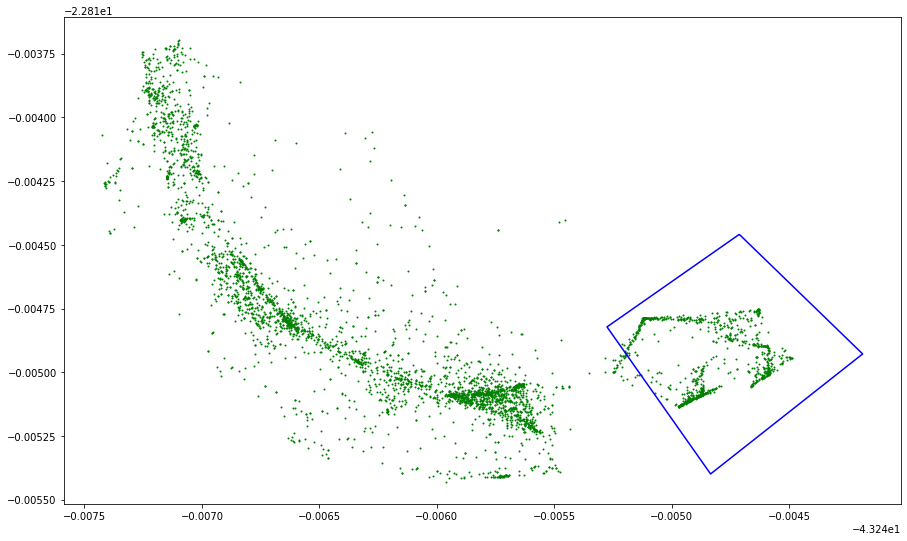

In [ ]:
# Plot points with Polygon
fig, ax = plt.subplots(figsize=(15,10))
gdf['geometry'].plot(ax = ax, color = "green", markersize = 1)
zone1.plot(ax = ax, facecolor = "none", edgecolor = "blue",lw = 1.5)
plt.show()

In [ ]:
# Functions to tell if point is inside or outside
mask = (zone1.loc[0, "geometry"])
pip_mask_geofence = gdf.within(mask)

In [ ]:
#Create PIP mask
gdf.loc[:,"geofence"] = pip_mask_geofence

In [ ]:
gdf['geofence'] = gdf['geofence'].replace({True: 'Inside', False: 'Outside'})

In [ ]:
gdf.sample(5)

,Building,Level,ClientMacAddr,lat,lng,category,timestamp,date,time,geometry,geofence
2234,TPS2,Level 1,d4:ae:05:b2:15:8d,-22.814999,-43.246130,passenger,2019-08-21 09:56:43.987,2019-08-21,09:56:43.987,POINT (-43.24613 -22.81500),Outside
42,TPS2,Level 1,84:16:f9:a9:97:01,-22.814788,-43.245119,device,2019-08-21 09:53:26.741,2019-08-21,09:53:26.741,POINT (-43.24512 -22.81479),Inside
2119,TPS2,Level 1,14:1f:78:2f:5f:0c,-22.814649,-43.246896,passenger,2019-08-21 09:56:33.643,2019-08-21,09:56:33.643,POINT (-43.24690 -22.81465),Outside
4006,TPS2,Level 1,1a:d6:c7:30:c8:d9,-22.815011,-43.245132,staff,2019-08-21 09:59:08.66,2019-08-21,09:59:08.66,POINT (-43.24513 -22.81501),Outside
1066,TPS2,Level 1,a8:16:d0:3f:d7:3b,-22.813895,-43.247181,staff,2019-08-21 09:54:56.899,2019-08-21,09:54:56.899,POINT (-43.24718 -22.81390),Outside


In [ ]:
# Count how many Points are inside the Zone1
a = gdf[gdf['geofence'] == "Inside"]
a.shape[0]

1147

In [ ]:
fig = px.scatter_mapbox(gdf,
                        lat=gdf.geometry.y,
                        lon=gdf.geometry.x,
                        zoom=8, width=1200, height=800, color = "geofence", size_max = 12)
fig.show()

In [ ]:
inside = gdf[gdf['geofence'] == "Inside"]

In [ ]:
uniq_mac = list(inside['ClientMacAddr'].unique())

In [ ]:
len(uniq_mac)

75

In [ ]:
categories_inside = list(inside['category'].unique())
categories_inside

['staff', 'device', 'passenger']

In [ ]:
inside['category'].value_counts()

staff        752
device       312
passenger     83
Name: category, dtype: int64

In [ ]:
if_condition = 'passenger' in categories_inside

In [ ]:
#Set up a customizable criteria: If passenger is in zone 1, then alert. If staff is in zone 1 then OK 
if if_condition == True :
  alarm = "Warning: There is a unauthorized device in a restricted zone"
if if_condition == False:
  alarm = "Situation OK: There isn't any unauthorized device in the restricted zone"

In [ ]:
print(alarm)

# Function - Geofencing

In [ ]:
#Function to create Polygon (in this case Zone 1 - square)
def create_polygon(coords, polygon_name):
 polygon = Polygon(coords)
 gdf = gpd.GeoDataFrame(crs = {"init" :"epsg:4326"})
 gdf.loc[0,"name"] = polygon_name
 gdf.loc[0, "geometry"] = polygon
 return gdf

In [ ]:
#Function to determine if point is inside or outside
def geofencing_function(dataframe,zone_coordinates):
  # Convert Pandas Dataframe to GeoPandas Dataframe
  geo_df = gpd.GeoDataFrame(dataframe, geometry=gpd.points_from_xy(dataframe.lng, dataframe.lat))
  zone = create_polygon(zone_coordinates,"zone_x")


  # Functions to tell if point is inside or outside
  mask = (zone.loc[0, "geometry"])
  pip_mask_geofence = geo_df.within(mask)

  #Create PIP mask
  geo_df.loc[:,"geofence"] = pip_mask_geofence

  geo_df['geofence'] = geo_df['geofence'].replace({True: 'Inside', False: 'Outside'})
  return geo_df

In [ ]:
coordinates_zone1 = [(-43.24471246167892,-22.814458938651967),(-43.24527556323677,-22.81482206116928),(-43.2448346208758,-22.815398982183833),
               (-43.24418730395855,-22.814928090082798)]

In [ ]:
df_sample = df0.sample(1000)

In [ ]:
#test function
test_df = geofencing_function(df_sample,coordinates_zone1)

/usr/local/lib/python3.7/dist-packages/pyproj/crs/crs.py:53: FutureWarning:

'+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: FutureWarning:

Assigning CRS to a GeoDataFrame without a geometry column is now deprecated and will not be supported in the future.



In [ ]:
test_df['geofence'].value_counts()

Outside    789
Inside     211
Name: geofence, dtype: int64

In [ ]:
test_df.sample(10)

,Building,Level,ClientMacAddr,lat,lng,localtime,category,geometry,geofence
3358256,TPS2,Level 1,da:a1:19:78:bb:c3,-22.814750,-43.246558,2019-08-05 06:42:17.795 UTC,passenger,POINT (-43.24656 -22.81475),Outside
6581976,TPS2,Level 1,70:fd:46:33:ae:5c,-22.814250,-43.247398,2019-08-16 06:47:07.299 UTC,passenger,POINT (-43.24740 -22.81425),Outside
7995483,TPS2,Level 1,98:10:e8:7c:a5:1c,-22.815007,-43.245598,2019-08-11 21:31:05.321 UTC,passenger,POINT (-43.24560 -22.81501),Outside
375285,TPS2,Level 1,90:cd:b6:51:40:85,-22.814653,-43.246743,2019-08-22 06:16:48.615 UTC,staff,POINT (-43.24674 -22.81465),Outside
8108762,TPS2,Level 1,32:cd:a7:ca:28:08,-22.814152,-43.247073,2019-08-12 02:05:47.278 UTC,passenger,POINT (-43.24707 -22.81415),Outside
5240144,TPS2,Level 1,54:13:79:f0:71:db,-22.815073,-43.245550,2019-08-08 03:21:26.334 UTC,staff,POINT (-43.24555 -22.81507),Outside
4957705,TPS2,Level 1,40:9b:cd:98:da:c5,-22.815093,-43.245923,2019-08-07 12:54:08.276 UTC,staff,POINT (-43.24592 -22.81509),Outside
11831762,TPS2,Level 1,30:4b:07:c0:0b:2f,-22.814039,-43.247089,2019-08-24 00:49:29.132 UTC,staff,POINT (-43.24709 -22.81404),Outside
6485054,TPS2,Level 1,84:16:f9:a9:81:20,-22.814788,-43.245118,2019-08-16 00:32:50.11 UTC,device,POINT (-43.24512 -22.81479),Inside
3942055,TPS2,Level 1,60:31:97:e7:49:30,-22.815075,-43.245722,2019-08-06 03:54:48.192 UTC,staff,POINT (-43.24572 -22.81508),Outside
